In [1]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# baixa os dados
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2024-09-19 13:34:31--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: 'spam.csv'

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.1s    

2024-09-19 13:34:32 (4.39 MB/s) - 'spam.csv' saved [503663/503663]



In [3]:
df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop nas colunas inúteis
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.columns

Index(['v1', 'v2'], dtype='object')

In [8]:
# renomeia as colunas 
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# cria labels binárias compatíveis com o Tensorflow
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
y = df['b_labels'].values

In [11]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [12]:
# criação dos conjuntos de treino e teste
df_train, df_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [13]:
# criação dos tokenizers e das sequências
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train) # cria um mapeamento para os dados de treino, que deve servir para os de teste também
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [14]:
# determinar o número de tokens únicos para informar a camada Embedding posteriormente
word2idx = tokenizer.word_index
V = len(word2idx)
V

7352

In [20]:
# add o padding aos dados de treino
data_train = pad_sequences(sequences_train)
T = data_train.shape[1] # número de tokens por sequência
data_train.shape

(3733, 189)

In [21]:
# add padding aos dados de teste
data_test = pad_sequences(sequences_test, maxlen = T) # limita as sequências a T tokens para manter compatibilidade com os dados de treino
data_test.shape

(1839, 189)

In [25]:
# cria o modelo

# dimensionalidade da camada de Embedding (hiperparâmetro, usuário escolhe)
D = 20

# a rede:
i = Input(shape = (T,)) # recebe um vetor com T tokens
x = Embedding(V + 1, D)(i) # o +1 é porque os índices começam em 1
x = Conv1D(filters = 32, kernel_size = 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(units = 1, activation = 'sigmoid')(x) # classificação binária

model = Model(i, x) # modelo com 1 input e 1 output

In [26]:
# compilação do modelo
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [27]:
# treinamento do modelo
r = model.fit(data_train, y_train, epochs = 5, validation_data = (data_test, y_test))

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8258 - loss: 0.4793 - val_accuracy: 0.9048 - val_loss: 0.1988
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9585 - loss: 0.1330 - val_accuracy: 0.9772 - val_loss: 0.0741
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9899 - loss: 0.0324 - val_accuracy: 0.9826 - val_loss: 0.0681
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9981 - loss: 0.0086 - val_accuracy: 0.9831 - val_loss: 0.0575
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9999 - loss: 0.0036 - val_accuracy: 0.9826 - val_loss: 0.0933


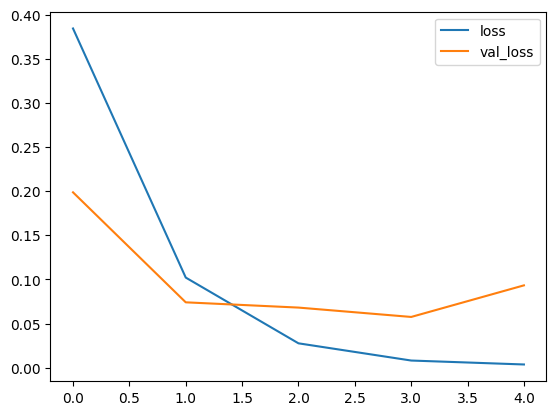

In [29]:
# visualização do erro
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()

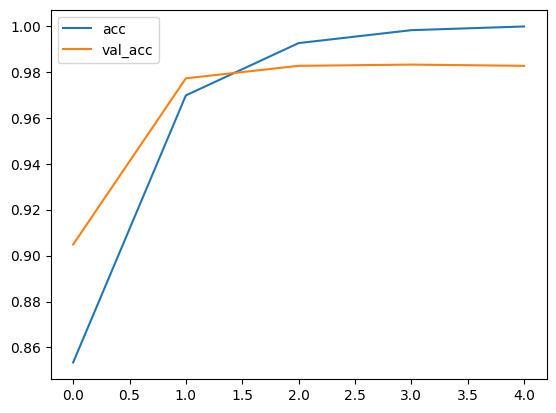

In [30]:
# visualização da precisão
plt.plot(r.history['accuracy'], label = 'acc')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()

### Conclusão
Observou-se um leve overfitting pelo aumento do erro para os dados teste na parte final do treino enquanto o erro para os dados de teste continuou caindo.<br>
Isso não pode ser observado pela medida da precisão, que se estabiliza rápido.